# Part 1

In [2]:
from sklearn.metrics import accuracy_score
from torchvision import transforms, datasets
import random, torch, os
import numpy as np
from torch.utils.data import DataLoader,Subset

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize( 
       mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225] 
    )
])

train = datasets.CIFAR10(root='.', train=True, download=True,
                          transform=transform)

test = datasets.CIFAR10(root='.', train=False, download=True, 
                        transform =transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]))

print('Number of training samples:', len(train))
print('Number of test samples:', len(test))

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of test samples: 10000


### 1. Use 3 Deep Learning Models to perform classification of CIFAR-10 dataset.
### defining three models

In [3]:
from torch import nn
from torchvision import models

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ResNet18, self).__init__()
        
        self.resnet = models.resnet18(pretrained=pretrained)
        self.resnet.fc = nn.Linear(512, num_classes)          

    def forward(self, x):
        out = self.resnet(x)
        return out

class Vgg11(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(Vgg11, self).__init__()
        
        vgg11 = models.vgg11(pretrained=pretrained)
                  
        self.feature_extractor = vgg11.features
        self.classifier = nn.Linear(512, num_classes)
                
    def forward(self, x):
        x = self.feature_extractor(x)
        out = self.classifier(x.view(x.shape[0],-1))
        return out

class Vgg16(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(Vgg16, self).__init__()
        
        vgg16 = models.vgg16(pretrained=pretrained)
                  
        self.feature_extractor = vgg16.features
        self.classifier = nn.Linear(512, num_classes)
                
                
    def forward(self, x):
        x = self.feature_extractor(x)
        out = self.classifier(x.view(x.shape[0],-1))
        return out


In [4]:
def getModel(model, pretrained=True):
    if model == 'resnet18':
        model = ResNet18(pretrained=pretrained)
    elif model == 'vgg11':
        model = Vgg11(pretrained=pretrained)
    elif model == 'vgg16':
        model = Vgg16(pretrained=pretrained)
    return model 

In [5]:
  
class calc (object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### 4. Split train data in 80:20 (Train: Validation) and perform 5-fold validation.
### Training

In [6]:
## writing the evaluation function
@torch.no_grad()
def evaluate(model, test, device, loss_func):
    pred_labels = []
    tgt_labels = []

    model.eval()
    loss_meter = calc()
    for step, batch in enumerate(test):
        img = batch[0].to(device)
        tgt = batch[1].to(device)
        # extracting predicted labels
        pred = model(img)
        loss = loss_func(pred, tgt)
        loss_meter.update(loss.item())
        pred_label = pred.argmax(1).cpu().numpy()
        tgt_label = batch[1].numpy()
        # appending predicted labels
        pred_labels.append(pred_label)
        tgt_labels.append(tgt_label)
    pred_labels = np.concatenate(pred_labels)
    tgt_labels = np.concatenate(tgt_labels)
    acc = accuracy_score(pred_labels, tgt_labels)
    return loss,acc

In [7]:
## hyper parameters for training
lr = 0.001
n_epochs = 10
batch_size = 128 
random.seed(43)
np.random.seed(43)
torch.manual_seed(43)
torch.cuda.manual_seed_all(43)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from sklearn.model_selection import StratifiedKFold
import time

skf = StratifiedKFold(n_splits=5)


for model_name in ['resnet18','vgg11', 'vgg16']:
    model = getModel(model_name)
    model.to(device)
    folds = skf.split(list(range(len(train))), train.targets)
    start = time.time()
    
    best_acc = 0
    
    for i, fold in enumerate(folds):
        train_index, val_index = fold

        train_split = Subset(train, train_index)
        val_split = Subset(train, val_index)

        train_data = DataLoader(train_split, batch_size=batch_size, 
                              shuffle=True, num_workers=4)
        valid_data = DataLoader(val_split, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        loss_func = nn.CrossEntropyLoss()

        train_losses = []
        train_accs = []
        valid_losses = []
        valid_accs = []
        
        for epoch_i in range(n_epochs):         
            loss_meter = calc()
            acc_meter = calc()
            
            model.train() 
            
            for step, batch in enumerate(train_data):
                img = batch[0].to(device)
                tgt = batch[1].to(device)
                        
                pred = model(img)
                loss = loss_func(pred, tgt)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                pred_label = pred.argmax(1).cpu().numpy()
                tgt_label = batch[1].numpy()
                
                acc = accuracy_score(pred_label, tgt_label)
                
                loss_meter.update(loss.item())
                acc_meter.update(acc)
 

            train_losses.append(loss_meter.avg)
            train_accs.append(acc_meter.avg)
            print(f"epoch:{epoch_i} train loss:{loss_meter.avg} train accuracy:{100 * acc_meter.avg} model:{model_name} fold:{i+1}")

        ## Evaluating the model
        val_loss,val_acc = evaluate(model, valid_data, device, loss_func)
        print(f"The validation accuracy:{val_acc}")
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)

        if val_acc > best_acc:
            os.makedirs(f'models/fold_{i+1}', exist_ok=True)
            torch.save(model.state_dict(), f'models/fold_{i+1}/{model_name}.pth')
            best_acc = val_acc
            best_fold = i+1
    stop = time.time()      
    print(f'best validation accuracy of {model_name} for fold {best_fold},training time: {stop-start}, best accuracy:{100*best_acc}')

### 5. Report the Training Time, model size and training accuracy for all 3 models.

### Resnet18 Model
Model: Resnet18\
Best fold: 5\
Training time: 153.99 sec\
Training accuracy: 93.6%\
model size: 44.8 MB\
validation accuracy: 90.99%

In [9]:
model = getModel('resnet18')

test_data = DataLoader(test, batch_size=batch_size, 
                     shuffle=False, num_workers=4)

# load model
model.load_state_dict(torch.load(f'models/fold_5/resnet18.pth'))
model.to(device)

## Evaluating the model
loss_func = nn.CrossEntropyLoss()
loss,test_acc = evaluate(model, test_data, device, loss_func)  
print('test accuracy of best resnet50:', test_acc * 100)

/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


test accuracy of best resnet50: 85.15


### VGG11 Model
Model: vgg11\
Best fold: 5\
Training time: 165.57 sec\
Training accuracy: 96.15%\
model size: 36.9 MB\
validation accuracy: 94.14%

In [10]:
model = getModel('vgg11')

test_data = DataLoader(test, batch_size=batch_size, 
                     shuffle=False, num_workers=4)

# load model
model.load_state_dict(torch.load(f'models/fold_5/vgg11.pth'))
model.to(device)

## Evaluating the model
loss_func = nn.CrossEntropyLoss()
loss,test_acc = evaluate(model, test_data, device, loss_func) 
print('test accuracy of best vgg11:', test_acc * 100)

/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


test accuracy of best vgg11: 87.58


### VGG16 Model
Model: vgg16\
Best fold: 4\
Training time: 263.26 sec\
Training accuracy: 90.03%\
model size: 58.9 MB\
validation accuracy: 92.87%

In [12]:
model = getModel('vgg16')

test_data = DataLoader(test, batch_size=batch_size, 
                     shuffle=False, num_workers=4)

# load model
model.load_state_dict(torch.load(f'models/fold_4/vgg16.pth'))
model.to(device)

## Evaluating the model
loss_func = nn.CrossEntropyLoss()
loss,test_acc = evaluate(model, test_data, device, loss_func) 
print('test accuracy of best vgg16:', test_acc * 100)

test accuracy of best vgg16: 89.1


### 6. Select 1 best model out of these 3 and report test accuracy as well as draw confusion matrix.

### Best Model is VGG16 fold 4

### confusion maatrix for the best model

/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


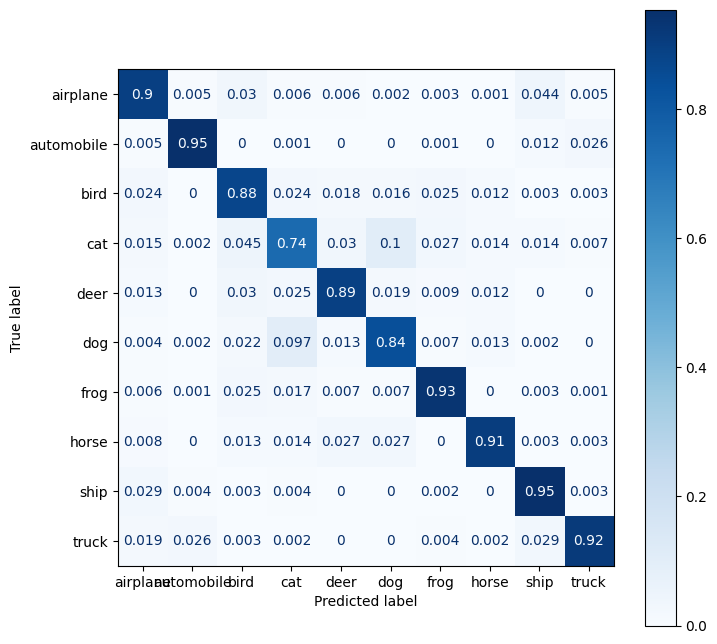

In [13]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


device = torch.device('cuda')
loss_func = nn.CrossEntropyLoss()

# load model
model = getModel('vgg16')
model.load_state_dict(torch.load(f'models/fold_4/vgg16.pth'))
model.to(device)

test_data = DataLoader(test, batch_size=batch_size, 
                     shuffle=False, num_workers=4)

# test model
pred_labels = []
tgt_labels = []

model.eval()
loss_meter = calc()
for step, batch in enumerate(test_data):
    img = batch[0].to(device)
    tgt = batch[1].to(device)

    pred = model(img)

    loss = loss_func(pred, tgt)
    loss_meter.update(loss.item())

    pred_label = pred.argmax(1).cpu().numpy()
    tgt_label = batch[1].numpy()

    pred_labels.append(pred_label)
    tgt_labels.append(tgt_label)

pred_labels = np.concatenate(pred_labels)
tgt_labels = np.concatenate(tgt_labels)
acc = accuracy_score(pred_labels, tgt_labels)
                                                            
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

disp = ConfusionMatrixDisplay.from_predictions(
        tgt_labels,
        pred_labels,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
    )
        
fig = disp.ax_.get_figure() 
fig.set_figwidth(8)
fig.set_figheight(8)  

# part 2

## Hypothesis test

## Hypothesis 1

### increasing the model size/complexity in general imroves the performance
### but it also depends on the size of dataset

In [14]:
# defining train and test function for all the hypothesis testing
def train_and_test(train, valid, test, lr=0.001,
                   n_epochs=20, batch_size=64, model_name='vgg16', 
                   fold=1, pretrained=True):
        
    random.seed(43)
    np.random.seed(43)
    torch.manual_seed(43)
    torch.cuda.manual_seed_all(43)
  
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = getModel(model_name, pretrained)
    model.to(device)
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_func = nn.CrossEntropyLoss()
    best_acc = 0
    
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    
    for epoch_i in range(n_epochs):         
        loss_meter = calc()
        acc_meter = calc()
        
        model.train() 
        
        for step, batch in enumerate(train):
            img = batch[0].to(device)
            tgt = batch[1].to(device)
                  
            pred = model(img)
            loss = loss_func(pred, tgt)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pred_label = pred.argmax(1).cpu().numpy()
            tgt_label = batch[1].numpy()
            
            acc = accuracy_score(pred_label, tgt_label)
            
            loss_meter.update(loss.item())
            acc_meter.update(acc)
            
            #print(f'train loss: {loss_meter.avg}, train accuracy:{100 * acc_meter.avg}')
        
        valid_loss, valid_acc = evaluate(model, valid, device, loss_func)   
    
        train_losses.append(loss_meter.avg)
        train_accs.append(acc_meter.avg)
      
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if valid_acc > best_acc:
            os.makedirs(f'models/fold_{fold}', exist_ok=True)
            torch.save(model.state_dict(), f'models/fold_{fold}/{model_name}_hypothesisTest.pth')
            best_acc = valid_acc
            
    # load model
    model.load_state_dict(torch.load(f'models/fold_{fold}/{model_name}_hypothesisTest.pth'))
    
    # test model
    test_loss, test_acc = evaluate(model, test, device, loss_func)   

    return 100 * test_acc


## Hypothesis-2 

### Batch size [64,32,16] are tested


In [16]:
model_name = 'vgg16'
best_fold = 4

lr = 0.001
n_epochs = 20

for batch_size in [16, 32, 64]:
    skf = StratifiedKFold(n_splits=5)

    # split data into 5 folds
    folds = skf.split(list(range(len(train))), train.targets)

    for i, fold in enumerate(folds):

        if (i + 1) != best_fold:
            continue

        train_index, val_index = fold

        train_split = Subset(train, train_index)
        val_split = Subset(train, val_index)

        train_data = DataLoader(train_split, batch_size=batch_size, 
                              shuffle=True, num_workers=4)
        valid_data = DataLoader(val_split, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

        test_data = DataLoader(test, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

        best_test_acc = train_and_test(train_data, valid_data, test_data, 
                                       lr, n_epochs, batch_size, model_name, i+1)

        print(f'best test accuracy of {model_name} for batch size {batch_size}: {best_test_acc:.2f}')

/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


best test accuracy of vgg16 for batch size 16: 79.51


/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


best test accuracy of vgg16 for batch size 32: 83.38


/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


best test accuracy of vgg16 for batch size 64: 85.41


### If we decrease the batchsize the accuracy suffers as we can see from the above experiment

## Hypothesis-3 

### Training dataset size [10k, 20k, 40k] are tested


In [22]:
model_name = 'vgg16'
best_fold = 4

lr = 0.001
n_epochs = 20
batch_size = 128

for sample_size in [10000, 20000, 40000]:
    skf = StratifiedKFold(n_splits=5)

    # split data into 5 folds
    folds = skf.split(list(range(len(train))), train.targets)

    for i, fold in enumerate(folds):

        if (i + 1) != best_fold:
            continue

        train_index, val_index = fold

        train_split = Subset(train, train_index[:sample_size])
        val_split = Subset(train, val_index)

        train_data = DataLoader(train_split, batch_size=batch_size, 
                              shuffle=True, num_workers=4)
        valid_data = DataLoader(val_split, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

        test_data = DataLoader(test, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

        best_test_acc = train_and_test(train_data, valid_data, test_data, lr, n_epochs, batch_size, model_name, i+1)

        print(f'best test accuracy of {model_name} for sample size {sample_size}: {best_test_acc:.2f}')

/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


best test accuracy of vgg16 for sample size 10000: 76.86


/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


best test accuracy of vgg16 for sample size 20000: 83.50


/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


best test accuracy of vgg16 for sample size 40000: 86.32


### The more sample size we have the more accuracy we get

## Hypothesis-4
### Model is trained with and without loading pretrained weight 

In [21]:
model_name= 'vgg16'
best_fold = 4

lr = 0.001
n_epochs = 20
batch_size = 128

for pretrained in [False, True]:
    skf = StratifiedKFold(n_splits=5)

    # split data into 5 folds
    folds = skf.split(list(range(len(train))), train.targets)

    for i, fold in enumerate(folds):

        if (i + 1) != best_fold:
            continue

        train_index, val_index = fold

        train_split = Subset(train, train_index)
        val_split = Subset(train, val_index)

        train_data = DataLoader(train_split, batch_size=batch_size, 
                              shuffle=True, num_workers=4)
        valid_data = DataLoader(val_split, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

        test_data = DataLoader(test, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

        best_test_acc = train_and_test(train_data, valid_data, test_data, lr, n_epochs, 
                                       batch_size, model_name, i+1, pretrained)
        
        stmt = "with" if pretrained else "without"
        print(f'best test accuracy of {model_name} {stmt} transfer learning: {best_test_acc:.2f}')

/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


best test accuracy of vgg11 without transfer learning: 82.39


/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


best test accuracy of vgg11 with transfer learning: 86.93


### As we can see from the above experiments transfer learning gives us much better result

## Hypothesis-5
### effect of regularization, tested for factors = [.00005,.0005,.005]

In [29]:
model_name= 'vgg16'
best_fold = 4

lr = 0.001
n_epochs = 20
batch_size = 128

random.seed(43)
np.random.seed(43)
torch.manual_seed(43)
torch.cuda.manual_seed_all(43)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = getModel(model_name, pretrained)
model.to(device)




loss_func = nn.CrossEntropyLoss()

factors = [.00005,.0005,.005]

for factor in factors:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=factor)
    train_losses = []
    train_accs = []
    
    folds = skf.split(list(range(len(train))), train.targets)

    for i, fold in enumerate(folds):

        if (i + 1) != best_fold:
            continue

        train_index, val_index = fold

        train_split = Subset(train, train_index)
        val_split = Subset(train, val_index)

        train_data = DataLoader(train_split, batch_size=batch_size, 
                              shuffle=True, num_workers=4)

        test_data = DataLoader(test, batch_size=batch_size, 
                              shuffle=False, num_workers=4)
        
        for epoch_i in range(n_epochs):         
                loss_meter = calc()
                acc_meter = calc()

                model.train() 

                for step, batch in enumerate(train_data):
                    img = batch[0].to(device)
                    tgt = batch[1].to(device)

                    pred = model(img)
                    loss = loss_func(pred, tgt)


                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    pred_label = pred.argmax(1).cpu().numpy()
                    tgt_label = batch[1].numpy()

                    acc = accuracy_score(pred_label, tgt_label)
                    loss_meter.update(loss.item())
                    acc_meter.update(acc)   
                train_losses.append(loss_meter.avg)
                train_accs.append(acc_meter.avg)
    loss, acc = evaluate(model, test_data, device, loss_func)
    print(f'best test accuracy of {model_name} for factor :{factor} is :{acc*100:.2f}')

/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rhossain/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


best test accuracy of vgg16 for factor :5e-05 is :85.86
best test accuracy of vgg16 for factor :0.0005 is :87.23
best test accuracy of vgg16 for factor :0.005 is :82.90


### As we can see there is no linear relation with the l2 regularization. It's more like hyper parameter.
### But in general regularization helps in the training